In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Utils

In [ ]:
def softmax(x, axis=1):
  x_exp = np.exp(x)
  return x_exp / x_exp.sum(axis=axis, keepdims=True)
  
def categorical_cross_entropy(target, p_hat):
  # target = [[0, 1, 0], [0, 0, 1]]
  # p_hat = [[0.04, 0.95, 0.01], [0.1, 0.8, 0.1]]
  # returns [-0.05129329, -2.30258509]
  assert isinstance(p_hat, np.ndarray)
  assert isinstance(target, np.ndarray)
  assert target.shape == p_hat.shape
  assert len(target.shape) == 2 and target.shape[1] > 1
  return  np.log(p_hat[np.nonzero(target)])

def log_loss(target, p_hat):
    return -categorical_cross_entropy(target, p_hat).mean()

# MulticlassLogisticRegression model class

In [ ]:
def ndarray_one_hot_encode(vec, width):
    assert isinstance(vec, np.ndarray)
    assert len(vec.shape) == 1
    n = vec.shape[0]
    mat = np.zeros((n, width))
    mat[np.arange(n), vec] = 1
    return mat


def one_hot_2_vec(vec):
    assert isinstance(vec, np.ndarray)
    assert len(vec.shape) == 2
    return np.argmax(vec, axis=1)


def accuracy(target, y_hat):
    assert isinstance(y_hat, np.ndarray)
    assert isinstance(target, np.ndarray)
    assert target.shape == y_hat.shape
    assert len(target.shape) == 1 or len(target.shape) == 2
    if len(target.shape) == 1:
      return (y_hat == target).mean()
    if len(target.shape) == 2:
      target_ind = one_hot_2_vec(target)
      y_hat_ind = one_hot_2_vec(y_hat)
      return (target_ind == y_hat_ind).mean()

In [ ]:
class MulticlassLogisticRegression:
  def __init__(self, n_steps, n_classes=None, learning_rate=0.001, plot_training_history=False):
    self._activation = softmax
    self._n_steps = n_steps
    self._K = n_classes
    self._D = None
    self._learning_rate = learning_rate
    self._fit_history = None
    self._plot_training_history = plot_training_history

    self._target_label_size = None
    self.weights = None
    self.biases = None
    

  def fit(self, X, Y):
    assert isinstance(X, np.ndarray) and len(X.shape) == 2
    assert isinstance(Y, np.ndarray)
    assert X.shape[0] == Y.shape[0]

    if len(Y.shape) == 1:
      print('Assume targets is 1d array with values corresponding to K classes')
      Y_Kd = ndarray_one_hot_encode(Y, self._K)
      self._target_label_size = 1
    else:
      print('Assume targets is one hot encoded Kd array with columns corresponding to K classes')
      assert np.all(Y.sum(axis=1) == np.ones(Y.shape[0]))
      Y_Kd = Y
      self._target_label_size = Y_Kd.shape[1]

    self._D = X.shape[1]
    if self._K is None:
      self._K = len(set(Y))
    
    w0, b0 = self._initialize_weights()
    self.weights, self.biases,  self._fit_history = self._backward(X, Y_Kd, self._n_steps, w0, b0, self._learning_rate)
    

  def predict(self, X):
    assert isinstance(X, np.ndarray)
    p_hat = self._forward(X, self.weights, self.biases)
    y_hat_ind = np.argmax(p_hat, axis=1)
    if self._target_label_size == 1:
      return y_hat_ind
    else:
      return ndarray_one_hot_encode(y_hat_ind, self._target_label_size)
  
  def score(self, X, Y):
    assert isinstance(Y, np.ndarray)
    if self._target_label_size == 1:
      assert len(Y.shape) == 1
    else:
      assert len(Y.shape) == 2
      assert Y.shape[1] == self._target_label_size
    y_hat = self.predict(X)
    return accuracy(Y, y_hat)

  
  def _initialize_weights(self):
    w0 = np.random.randn(self._D, self._K) / np.sqrt(self._D)
    b0 = np.random.randn(self._K)
    return w0, b0
      

  def _backward(self, x, y, n_steps, w0, b0, learning_rate):
    hist = []

    p_hat = self._forward(x, w0, b0)
    loss_start = log_loss(y, p_hat)
    acc_start = accuracy(np.argmax(y, axis=1), np.argmax(p_hat, axis=1))
    hist.append(np.array([loss_start, acc_start]))

    w = w0
    b = b0
    for step in range(1, n_steps+1):
      d_w = self._dw(x, y, p_hat)
      d_b = self._db(y, p_hat)
      w = w + learning_rate * d_w
      b = b + learning_rate * d_b

      p_hat = self._forward(x, w, b)
      loss = log_loss(y, p_hat)
      acc = accuracy(np.argmax(y, axis=1), np.argmax(p_hat, axis=1))
      hist.append(np.array([loss, acc]))      

    hist = np.array(hist)
    if self._plot_training_history:
      plt.figure(figsize=(10,5))
      plt.plot(-1 *hist[:,0], label='loss')
      plt.legend()
      plt.show()

      plt.figure(figsize=(10,5))
      plt.plot(hist[:,1], label='accuracy')
      plt.legend()
      plt.show()
      print(f'final cost={hist[-1,0]}, final accuracy={hist[-1,1]}')

    return w, b, hist
  
  def _forward(self, x, w, b):
    assert isinstance(x, np.ndarray)
    return self._activation(x.dot(w) + b)

  def _dw(self, x, y, p_hat):
    return x.T.dot(y-p_hat)

  def _db(self, y, p_hat):
    return np.sum(y-p_hat, axis=0)

# Use multiclass logistic regrression

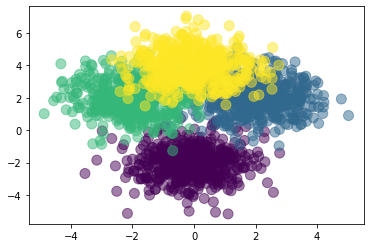

In [ ]:
def det_simple_cloud_data(Nclass):
  X1 = np.random.randn(Nclass, 2) + np.array([0, -2])
  X2 = np.random.randn(Nclass, 2) + np.array([2, 2])
  X3 = np.random.randn(Nclass, 2) + np.array([-2, 2])
  X4 = np.random.randn(Nclass, 2) + np.array([0, 4])
  X = np.vstack([X1, X2, X3, X4])

  Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass + [3]*Nclass)
  return X, Y

Xtrain, Ytrain = det_simple_cloud_data(500)
Xtest, Ytest = det_simple_cloud_data(100)

plt.scatter(Xtrain[:,0], Xtrain[:, 1], c=Ytrain, s=100, alpha=0.5)
plt.show()

D = 2  # dimensionality of input
M1 = 3  # hidden layer size
M2 = 5  # hidden layer size
K = 4  # number of classes

Ttrain = ndarray_one_hot_encode(Ytrain, K)
Ttest = ndarray_one_hot_encode(Ytest, K)

Assume targets is 1d array with values corresponding to K classes


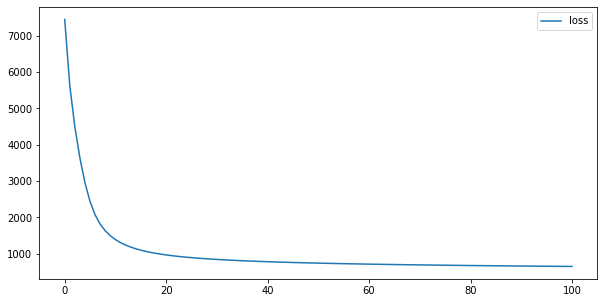

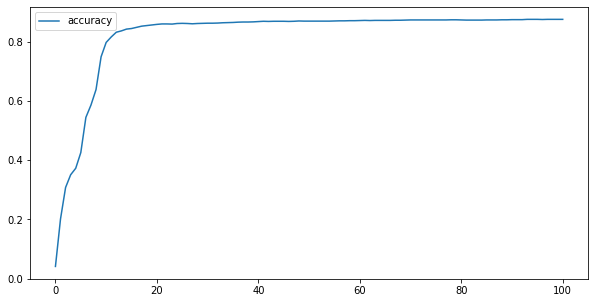

final cost=-646.8247152301869, final accuracy=0.8765
Train accuracy: 0.8765
Test accuracy: 0.8725


In [ ]:
model = MulticlassLogisticRegression(n_steps=100, n_classes=K, learning_rate=0.0001, plot_training_history=True)
model.fit(Xtrain, Ytrain)

assert model.score(Xtrain, model.predict(Xtrain)) == 1

print('Train accuracy:', model.score(Xtrain, Ytrain))
print('Test accuracy:', model.score(Xtest, Ytest))